In [1]:
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
import pandas as pd
from scipy import interpolate
from scipy import stats
from datetime import datetime, timedelta
import pytz
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects
import geopandas as gpd
import tqdm.auto as tqdm
from glob import glob
import ee

In [2]:
ee.Authenticate()
ee.Initialize()

In [3]:
files = sorted(glob("shoreline_data_run6/nzd*/time_series_tidally_corrected.csv"))
len(files)
pd.read_csv(files[0]).tail()

,Unnamed: 0,dates,nzd0001-0000,nzd0001-0001,nzd0001-0002,nzd0001-0003,nzd0001-0004,nzd0001-0005,nzd0001-0006,nzd0001-0007,...,nzd0001-0023,nzd0001-0024,nzd0001-0025,nzd0001-0026,nzd0001-0027,nzd0001-0028,nzd0001-0029,nzd0001-0030,nzd0001-0031,nzd0001-0032
177,177,2021-05-01 22:17:07+00:00,174.702851,NaN,178.023459,191.815325,204.759809,NaN,245.847728,265.100128,...,252.020917,248.925421,248.447457,253.193736,250.380017,259.676887,254.461642,255.974983,254.995313,260.239137
178,178,2021-05-17 22:17:12+00:00,NaN,NaN,NaN,NaN,NaN,NaN,234.706588,245.093471,...,226.345775,225.327493,222.358132,229.342560,237.483581,243.185903,238.876358,230.442660,228.176415,237.143330
179,179,2021-06-18 22:17:27+00:00,NaN,NaN,185.730259,NaN,196.514209,217.74784,234.805771,224.857692,...,211.269169,210.184038,212.404057,217.483880,224.446490,244.339407,240.928149,247.393279,247.946689,259.091928
180,180,2021-07-04 22:17:29+00:00,180.263301,NaN,177.743235,NaN,194.454097,NaN,239.352236,NaN,...,225.452269,223.574190,223.746108,231.444424,240.131786,245.887173,246.759335,252.158740,250.708964,259.146114
181,181,2021-09-22 22:17:53+00:00,NaN,NaN,163.745652,NaN,189.369697,NaN,225.546755,240.039959,...,212.920671,206.178345,201.300026,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
poly = gpd.read_file("polygons.geojson")
poly = poly[poly.id.str.startswith("nzd")]
poly.set_index("id", inplace=True)
poly

,area,id_sorted,northing,geometry
id,,,,
nzd0001,3.069093e+06,nzd0001,-4.085604e+06,"POLYGON ((172.96406 -34.43054, 172.99324 -34.4..."
nzd0002,1.507931e+06,nzd0002,-4.086100e+06,"POLYGON ((172.93456 -34.42857, 172.95856 -34.4..."
nzd0003,2.484730e+06,nzd0003,-4.087232e+06,"POLYGON ((173.00980 -34.42055, 173.00088 -34.4..."
nzd0006,9.619509e+05,nzd0004,-4.090732e+06,"POLYGON ((173.00532 -34.46694, 173.00612 -34.4..."
nzd0007,3.109433e+06,nzd0005,-4.095516e+06,"POLYGON ((172.99847 -34.48102, 173.00081 -34.5..."
...,...,...,...,...
nzd0317,9.986110e+05,nzd0556,-4.971830e+06,"POLYGON ((172.32302 -40.71870, 172.31210 -40.7..."
nzd0316,4.300058e+06,nzd0557,-4.966165e+06,"POLYGON ((172.37076 -40.70229, 172.39571 -40.6..."
nzd0313,2.291974e+07,nzd0558,-4.939929e+06,"POLYGON ((172.89281 -40.50518, 172.73306 -40.5..."


In [5]:
sitename = "nzd0001"
inputs = {
    "polygon": list(poly.geometry[sitename].exterior.coords),
    "dates": ['2021-09-22', '2025-12-12'],
    "sat_list": ['L5','L7','L8'],
    "sitename": sitename,
    "filepath": 'data',
    "landsat_collection": 'C02',
}
result = SDS_download.check_images_available(inputs)

Number of images available between 2021-09-22 and 2025-12-12:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     L5: 0 images
     L7: 2 images
     L8: 53 images
  Total images available to download from Tier 1: 55 images
  Total images available to download from Tier 2: 0 images


In [6]:
metadata = SDS_download.retrieve_images(inputs)

Number of images available between 2021-09-22 and 2025-12-12:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     L5: 0 images
     L7: 2 images
     L8: 53 images
L5:There are 0 images available, 0 images already exist, 0 to download
L7:There are 2 images available, 0 images already exist, 2 to download
L8:There are 53 images available, 0 images already exist, 53 to download
  Total images available to download from Tier 1: 55 images
  Total images available to download from Tier 2: 0 images


nzd0001: Downloading Imagery for 3 satellites:   0%|          | 0/3 [00:00<?, ?it/s]

nzd0001: No images to download for L5


nzd0001: Downloading Imagery for L7:   0%|          | 0/2 [00:00<?, ?it/s]

skipping image '2023-01-04-20-25-07_L7_nzd0001_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%
skipping image '2023-03-01-20-19-07_L7_nzd0001_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%


nzd0001: Downloading Imagery for L8:   0%|          | 0/53 [00:00<?, ?it/s]

skipping image '2021-10-08-22-17-59_L8_nzd0001_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%
skipping image '2021-12-27-22-17-52_L8_nzd0001_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%
skipping image '2022-01-28-22-17-44_L8_nzd0001_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%
skipping image '2022-02-13-22-17-40_L8_nzd0001_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%
skipping image '2022-03-01-22-17-36_L8_nzd0001_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%
skipping image '2022-03-17-22-17-30_L8_nzd0001_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%
skipping image '2022-04-02-22-17-19_L8_nzd0001_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%
skipping image '2022-04-18-22-17-25_L8_nzd0001_ms.tif' due to cloud and no data cover 96.36% exceeds threshold of 95.00%
skipping image '2022-05-2

In [31]:
shorelines = gpd.read_file("shorelines.geojson")
shorelines = shorelines[shorelines.id.str.startswith("nzd")]
shorelines.set_index("id", inplace=True)
shorelines

,area,beach_length,easting,name,northing,Tide range,median_orientation,id_sorted,same_beach,median_slope,ci,n_points,n_points_nonan,geometry
id,,,,,,,,,,,,,,
nzd0001,3069093.23458588,3280.911041046786,-4085604.140438608,noname,-4085604.140438608,NaN,330.147924,nzd0001,None,0.081742,0.02980,182.0,169.0,"LINESTRING (172.96361 -34.42582, 172.96963 -34..."
nzd0002,1507930.546890622,2189.974013881022,-4086099.59937183,noname,-4086099.59937183,NaN,355.515394,nzd0002,None,0.053485,0.01355,177.0,155.5,"LINESTRING (172.93654 -34.42609, 172.94200 -34..."
nzd0003,2484729.888105999,3138.870291311147,-4087231.976772245,noname,-4087231.976772245,NaN,104.328215,nzd0003,None,0.042784,0.01020,184.0,139.5,"LINESTRING (173.01297 -34.42323, 173.00958 -34..."
nzd0006,961950.925675486,1363.421092558937,-4090731.986757715,noname,-4090731.986757715,NaN,91.301953,nzd0004,None,0.044396,0.01000,186.0,153.0,"LINESTRING (173.00362 -34.45492, 173.00349 -34..."
nzd0007,3109432.836591786,3576.694135751825,-4095515.823155831,noname,-4095515.823155831,NaN,81.607075,nzd0005,None,0.052095,0.01755,178.0,131.0,"LINESTRING (173.00337 -34.48261, 173.00144 -34..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nzd0317,998611.0209522904,1388.636895098391,-4971829.852334809,noname,-4971829.852334809,NaN,309.396745,nzd0556,None,0.051980,0.00530,397.0,301.0,"LINESTRING (172.31541 -40.72839, 172.31783 -40..."
nzd0316,4300057.774234623,4647.035750366853,-4966165.280134064,noname,-4966165.280134064,NaN,304.531268,nzd0557,None,0.057371,0.00780,363.0,266.0,"LINESTRING (172.36751 -40.69864, 172.37020 -40..."
nzd0313,22919741.04033367,17378.17283613481,19237414.32246552,noname,-4939929.050573792,NaN,6.636156,nzd0558,None,0.026684,0.00570,324.0,125.0,"LINESTRING (172.73493 -40.50746, 172.73502 -40..."


In [40]:
# settings for the shoreline extraction
settings = {
    # general parameters:
    'cloud_thresh': 0.1,        # threshold on maximum cloud cover
    'dist_clouds': 300,         # ditance around clouds where shoreline can't be mapped
    'output_epsg': 2193,       # epsg code of spatial reference system desired for the output
    # quality control:
    'check_detection': False,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': True,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 1000,     # minimum area (in metres^2) for an object to be labelled as a beach
    'min_length_sl': 500,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': False,  # switch this parameter to True if sand pixels are masked (in black) on many images
    'sand_color': 'default',    # 'default', 'latest', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    'pan_off': False,           # True to switch pansharpening off for Landsat 7/8/9 imagery
    's2cloudless_prob': 40,      # threshold to identify cloud pixels in the s2cloudless probability mask
    # add the inputs defined previously
    'inputs': inputs,
}

# [OPTIONAL] preprocess images (cloud masking, pansharpening/down-sampling)
SDS_preprocess.save_jpg(metadata, settings, use_matplotlib=True)

Saving images as jpg:
L5: 0 images

L7: 0 images

L8: 36 images
100%
Satellite images saved as .jpg in data/nzd0001/jpg_files/preprocessed


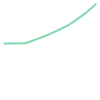

In [83]:
shorelines.geometry[sitename]

In [35]:
settings['reference_shoreline'] = list(shorelines.geometry[sitename].coords)
settings['max_dist_ref'] = 100 # max distance (in meters) allowed from the reference shoreline

In [42]:
output = SDS_shoreline.extract_shorelines(metadata, settings)

L5: Mapping Shorelines: 0it [00:00, ?it/s]

L7: Mapping Shorelines: 0it [00:00, ?it/s]

L8: Mapping Shorelines:   0%|          | 0/36 [00:00<?, ?it/s]

In [127]:
# Have to flip to get x,y?
output['shorelines'] = [np.flip(s) for s in output['shorelines']]

In [128]:
output = SDS_tools.remove_duplicates(output) # removes duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_inaccurate_georef(output, 10) # remove inaccurate georeferencing (set threshold to 10 m)

0 duplicates
0 bad georef


In [129]:
from pyproj import CRS
geomtype = 'points' # choose 'points' or 'lines' for the layer geometry
gdf = SDS_tools.output_to_gdf(output, geomtype)
if gdf is None:
    raise Exception("output does not contain any mapped shorelines")
gdf.crs = CRS(settings['output_epsg']) # set layer projection
# save GEOJSON layer to file
gdf.to_file(os.path.join(inputs['filepath'], inputs['sitename'], '%s_output_%s.geojson'%(sitename,geomtype)),
                                driver='GeoJSON', encoding='utf-8')

In [132]:
gdf.explore("date", legend=True, tiles="Esri.WorldImagery")

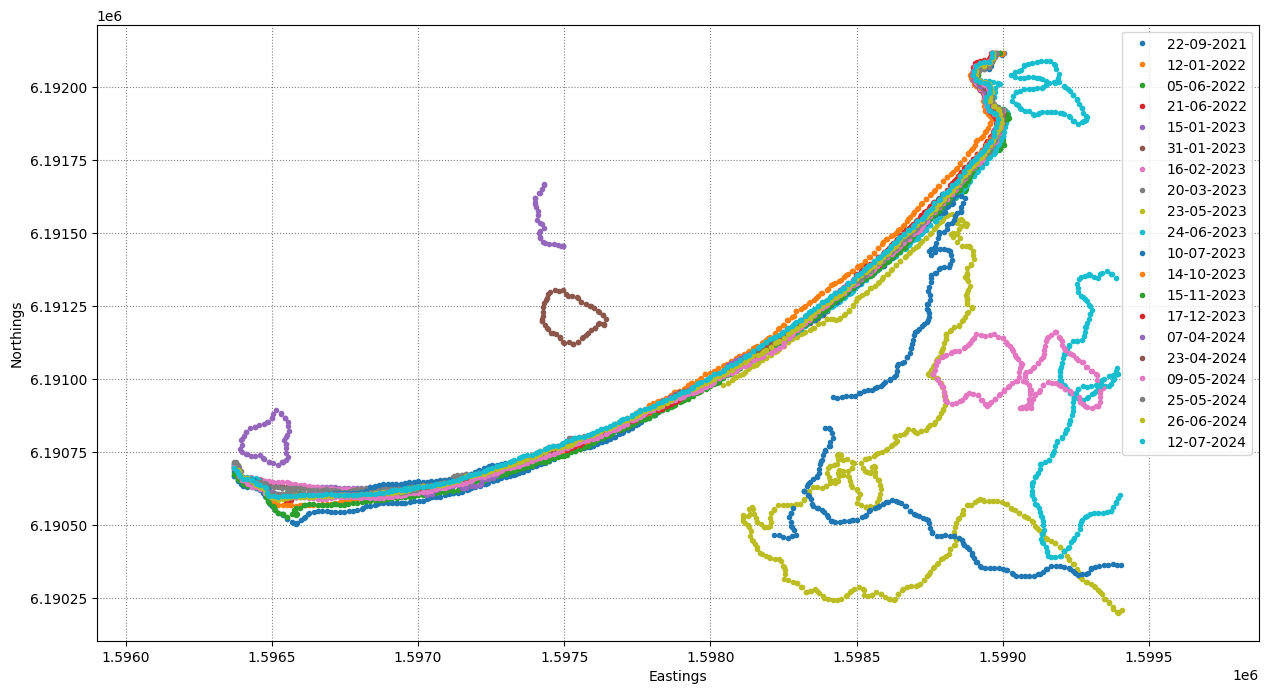

In [133]:
%matplotlib inline
fig = plt.figure(figsize=[15,8])
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
plt.legend()

In [105]:
transects_gdf = gpd.read_file("transects.geojson")
transects_gdf.set_index("id", inplace=True)
transects_gdf = transects_gdf[transects_gdf.site_id == sitename]
transects_gdf

,site_id,orientation,along_dist,along_dist_norm,beach_slope,cil,ciu,trend,n_points,n_points_nonan,geometry
id,,,,,,,,,,,
nzd0001-0000,nzd0001,359.037136,3197.737936,1.000000,0.050,0.0397,0.0679,-3.130269,182.0,145.0,"LINESTRING (172.96364 -34.42730, 172.96358 -34..."
nzd0001-0001,nzd0001,359.037136,3097.737936,0.968728,NaN,NaN,NaN,-2.328981,182.0,38.0,"LINESTRING (172.96454 -34.42729, 172.96448 -34..."
nzd0001-0002,nzd0001,359.037136,2997.737936,0.937456,0.060,0.0478,0.0776,-2.961207,182.0,168.0,"LINESTRING (172.96544 -34.42728, 172.96537 -34..."
nzd0001-0003,nzd0001,359.037136,2897.737936,0.906184,NaN,NaN,NaN,-2.121564,182.0,60.0,"LINESTRING (172.96633 -34.42727, 172.96627 -34..."
nzd0001-0004,nzd0001,359.037136,2797.737936,0.874912,0.055,0.0450,0.0664,-2.587407,182.0,173.0,"LINESTRING (172.96723 -34.42726, 172.96717 -34..."
nzd0001-0005,nzd0001,359.037136,2697.737936,0.843639,NaN,NaN,NaN,-2.165299,182.0,84.0,"LINESTRING (172.96813 -34.42724, 172.96807 -34..."
nzd0001-0006,nzd0001,355.601961,2597.737936,0.812367,0.065,0.0571,0.0812,-1.928216,182.0,174.0,"LINESTRING (172.96914 -34.42723, 172.96886 -34..."
nzd0001-0007,nzd0001,343.700467,2499.496030,0.781645,0.060,0.0525,0.0722,-1.975691,182.0,151.0,"LINESTRING (172.97038 -34.42707, 172.96937 -34..."
nzd0001-0008,nzd0001,335.444503,2399.496030,0.750373,0.065,0.0540,0.0753,-1.623201,182.0,172.0,"LINESTRING (172.97144 -34.42669, 172.96994 -34..."


In [109]:
transects = {}
for transect_id in transects_gdf.index:
    transects[transect_id] = np.array(transects_gdf.geometry.to_crs(settings["output_epsg"])[transect_id].coords)
transects

{'nzd0001-0000': array([[1596659.01462846, 6190463.06085984],
        [1596653.34842453, 6190791.67035612]]),
 'nzd0001-0001': array([[1596741.5422731 , 6190464.47080105],
        [1596735.87898069, 6190793.0803936 ]]),
 'nzd0001-0002': array([[1596824.06994193, 6190465.88001102],
        [1596818.40956103, 6190794.48969987]]),
 'nzd0001-0003': array([[1596906.59763493, 6190467.28848976],
        [1596900.94016556, 6190795.89827494]]),
 'nzd0001-0004': array([[1596989.12535214, 6190468.69623727],
        [1596983.47079428, 6190797.3061188 ]]),
 'nzd0001-0005': array([[1597071.65309355, 6190470.10325354],
        [1597066.00144721, 6190798.71323146]]),
 'nzd0001-0006': array([[1597164.06578181, 6190471.97322957],
        [1597138.64685413, 6190799.65588957]]),
 'nzd0001-0007': array([[1597278.05289224, 6190489.21507917],
        [1597185.29519944, 6190804.63651561]]),
 'nzd0001-0008': array([[1597375.38782899, 6190531.64522092],
        [1597238.09246933, 6190830.54103537]]),
 'nzd0001-

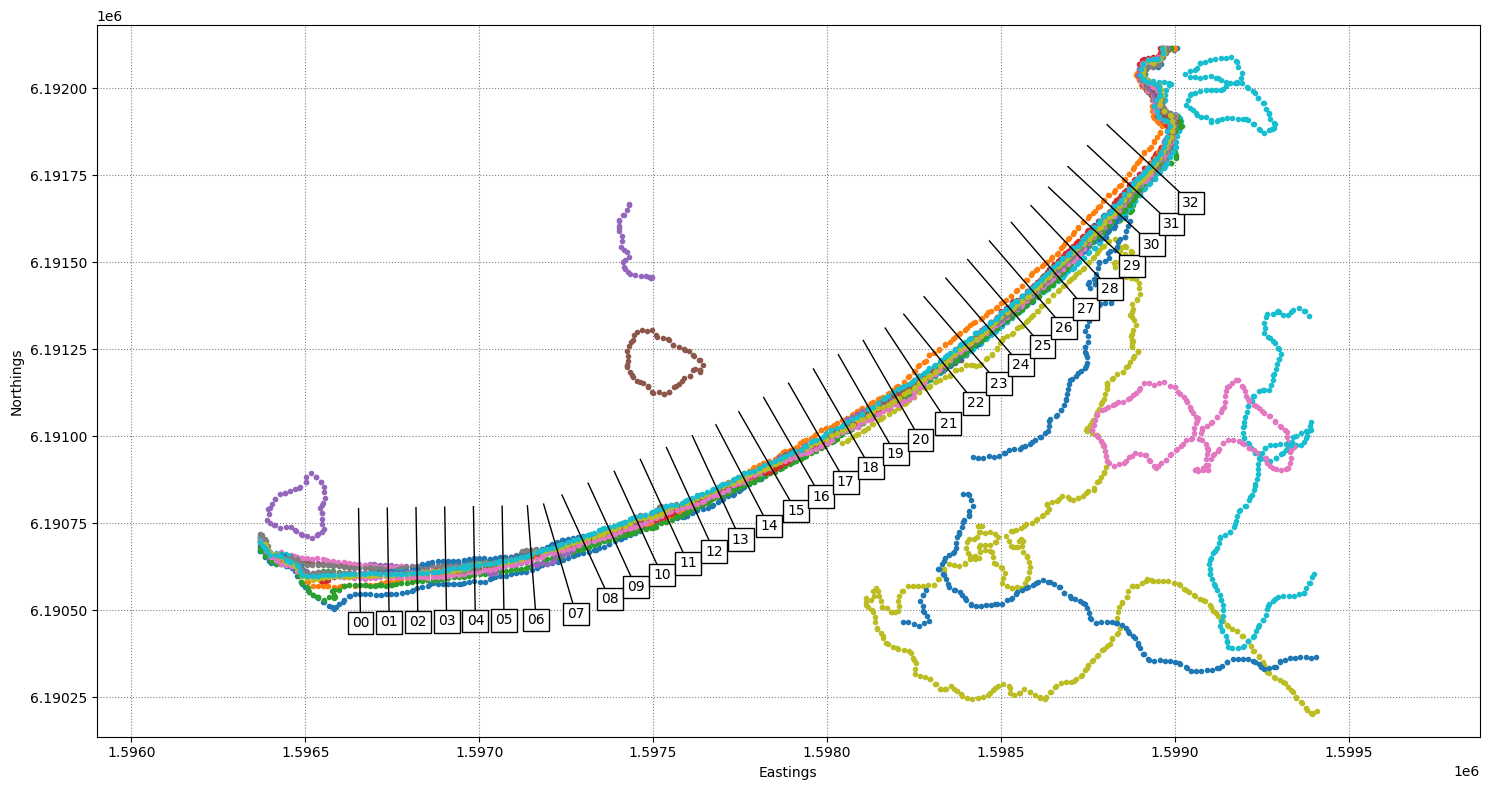

In [139]:
fig = plt.figure(figsize=[15,8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
for i,key in enumerate(list(transects.keys())):
    plt.plot(transects[key][0,0],transects[key][0,1], 'bo', ms=5)
    plt.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    plt.text(transects[key][0,0], transects[key][0,1], key.replace(f"{sitename}-00", ""),
                va='center', ha='center', bbox=dict(boxstyle="square", ec='k',fc='w'))

In [140]:
settings_transects = { # parameters for computing intersections
                      'along_dist':          25,        # along-shore distance to use for computing the intersection
                      'min_points':          3,         # minimum number of shoreline points to calculate an intersection
                      'max_std':             15,        # max std for points around transect
                      'max_range':           30,        # max range for points around transect
                      'min_chainage':        -100,      # largest negative value along transect (landwards of transect origin)
                      'multiple_inter':      'auto',    # mode for removing outliers ('auto', 'nan', 'max')
                      'auto_prc':            0.1,       # percentage of the time that multiple intersects are present to use the max
                     }
cross_distance = SDS_transects.compute_intersection_QC(output, transects, settings_transects) 

Computing transect shoreline intersections:   0%|          | 0/33 [00:00<?, ?it/s]

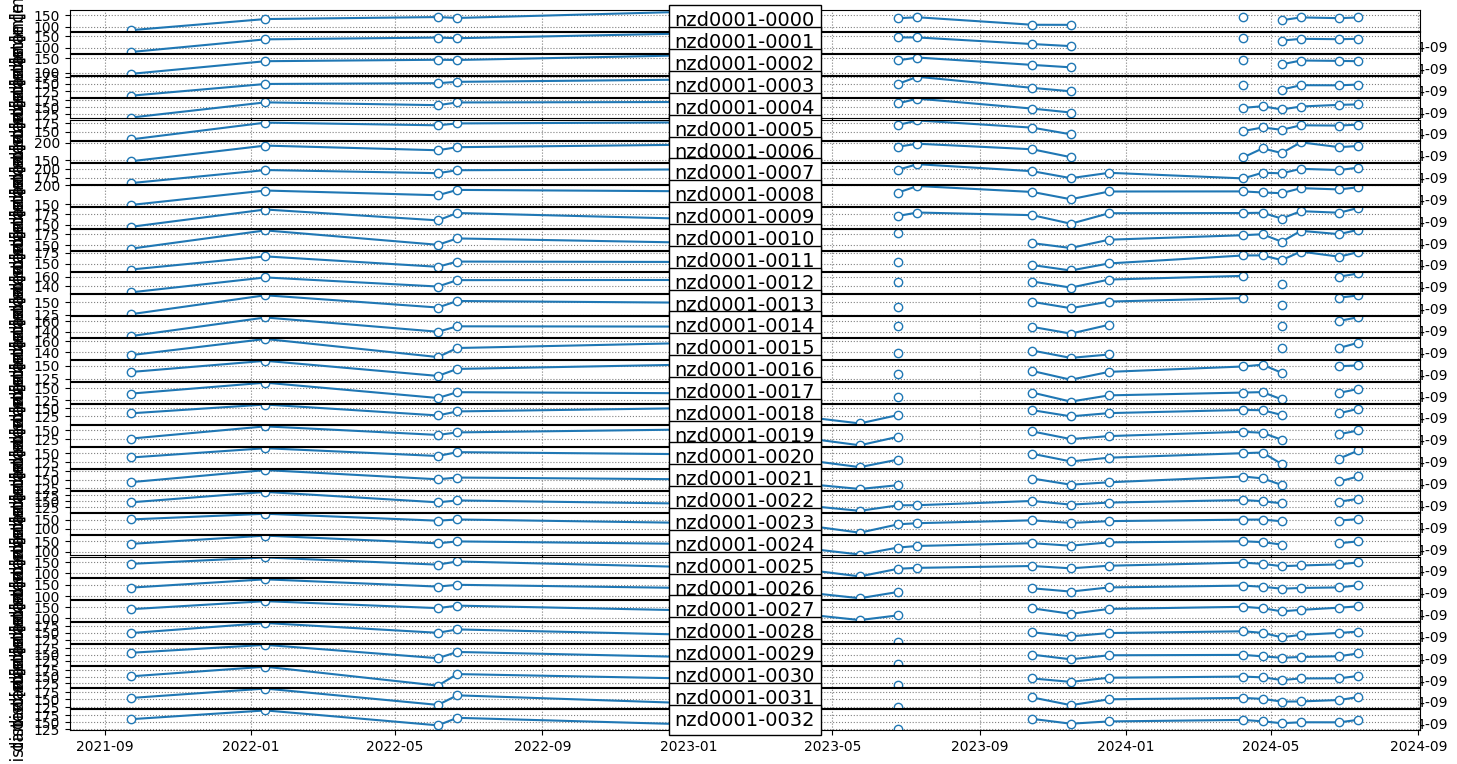

In [141]:
fig = plt.figure(figsize=[15,8], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(output['dates'], cross_distance[key], '-o', ms=6, mfc='w')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)  

In [142]:
# save a .csv file for Excel users
out_dict = dict([])
out_dict['dates'] = output['dates']
for key in transects.keys():
    out_dict[key] = cross_distance[key]
df = pd.DataFrame(out_dict)
fn = os.path.join(settings['inputs']['filepath'],settings['inputs']['sitename'],
                  'transect_time_series.csv')
df.to_csv(fn, sep=',')
print('Time-series of the shoreline change along the transects saved as:\n%s'%fn)

Time-series of the shoreline change along the transects saved as:
data/nzd0001/transect_time_series.csv


In [143]:
df

,dates,nzd0001-0000,nzd0001-0001,nzd0001-0002,nzd0001-0003,nzd0001-0004,nzd0001-0005,nzd0001-0006,nzd0001-0007,nzd0001-0008,...,nzd0001-0023,nzd0001-0024,nzd0001-0025,nzd0001-0026,nzd0001-0027,nzd0001-0028,nzd0001-0029,nzd0001-0030,nzd0001-0031,nzd0001-0032
0,2021-09-22 22:17:53+00:00,83.995757,81.787155,95.698116,108.460779,113.029968,127.755404,146.178155,159.617541,147.577238,...,151.476529,136.956352,142.307142,136.905274,140.603472,148.590711,157.089487,150.847571,154.818889,160.968272
1,2022-01-12 22:17:49+00:00,133.396314,137.063682,139.783860,149.378674,167.015556,176.033662,191.850194,195.840136,186.320600,...,182.934916,175.196101,171.838167,173.340461,175.808217,184.269476,188.589745,187.603221,185.920086,192.239041
2,2022-06-05 22:17:39+00:00,142.264565,144.901308,144.838613,152.135213,157.068090,168.354473,178.338623,187.135836,173.638520,...,144.457185,139.426005,138.676113,141.390256,145.223027,149.458190,135.429144,115.164184,131.772296,138.974241
3,2022-06-21 22:17:48+00:00,138.298777,142.037626,144.003933,156.852858,166.679992,173.735634,187.281870,195.327162,187.966323,...,151.154408,148.247729,153.429839,149.254699,156.200412,161.483881,160.279340,159.366572,163.466698,165.769675
4,2023-01-15 22:17:53+00:00,168.297928,164.482031,161.677066,165.176444,168.470090,177.028011,195.009883,197.645250,184.021962,...,130.736144,135.986685,125.768892,134.137654,133.896649,141.355298,138.677459,141.189373,135.621971,140.754911
5,2023-01-31 22:17:58+00:00,161.385879,149.602734,148.261270,149.556958,156.547426,168.358297,180.930806,194.295573,181.519488,...,128.440965,125.406992,126.618188,126.880812,128.250485,134.398973,132.553433,134.837130,132.361790,133.798503
6,2023-02-16 22:17:50+00:00,167.068564,160.284586,158.701459,161.062323,163.711119,173.197471,193.653518,195.377617,183.424582,...,146.308030,129.453646,131.254778,130.765603,137.609423,142.439559,138.995319,137.448312,138.203048,141.547960
7,2023-03-20 22:17:28+00:00,158.454506,151.641065,159.034092,164.453373,171.720433,181.477172,199.881020,204.272485,191.521094,...,135.590502,128.644917,128.305353,126.488948,128.546499,129.561748,128.451057,126.147361,129.868723,134.662229
8,2023-05-23 22:16:53+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,77.772394,87.354521,84.361414,90.269788,92.717781,NaN,NaN,NaN,NaN,NaN
9,2023-06-24 22:17:06+00:00,137.149571,145.416324,142.865898,149.898048,163.325130,169.331511,188.712745,196.711330,180.951384,...,124.297822,119.925713,119.701816,117.959879,113.593113,116.908137,113.101239,118.677883,123.207322,124.722507
